# 【問題1】ラグランジュの未定乗数法による最急降下

# 【問題2】サポートベクターの決定

* ラグランジュ乗数の更新式
$$
\lambda_i^{new} = \lambda_i + a(1 - \sum_{j=1}^{n}\lambda_j y_i y_j k(x_i, x_j))\\
$$

In [1]:
import numpy as np

In [2]:
class ScratchSVMClassifier():
    
    """
    SVM分類器のスクラッチ実装
    
    Parameters
    ----------
    num_iter : int
      イテレーション数
    lr : float
      学習率
    kernel : str
      カーネルの種類。線形カーネル（linear）か多項式カーネル（polly）
    threshold : float
      サポートベクターを選ぶための閾値
    verbose : bool
      学習過程を出力する場合はTrue
      
    Attributes
    ----------
    self.n_support_vectors : int
      サポートベクターの数
    self.index_support_vectors : 次の形のndarray, shape (n_support_vectors,)
      サポートベクターのインデックス
    self.X_sv :  次の形のndarray, shape(n_support_vectors, n_features)
      サポートベクターの特徴量
    self.lam_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターの未定乗数
    self.y_sv :  次の形のndarray, shape(n_support_vectors, 1)
      サポートベクターのラベル
          
    """
    
    def __init__(self, num_iter, lr, kernel='linear', threshold=1e-5, verbose=False):
        # ハイパーパラメータを属性として記録
        self.iter = num_iter
        self.lr = lr
        self.kernel = kernel
        self.threshold = threshold
        self.verbose = verbose
        
        self.init_lambda = np.ones(n_samples)
        
        #訓練データ保存
        self.n_support_vectors = 0
        self.index_support_vectors = []
        self.X_sv = []
        self.y_sv = []
        self.lam_sv = []
        
        #検証データ保存
        self.n_support_vectors_val = 0
        self.index_support_vectors_val = []
        self.X_sv_val = []
        self.y_sv_val = []
        self.lam_sv_val = []
        
            
    def _kernel(self, X):
        """
        カーネルトリックを行う：線形カーネル
        
        Parameters
        ----------
         X : 次の形のndarray, shape (n_samples, n_features)
              訓練データの特徴量
              
        Returns
        -------
            次の形のndarray, shape (n_samples, n_samples)

        """
        
        K = X.dot(X.T)
        
        return K
    
    
    
    def lagrange(self, X, y):
        """
        ラグランジュ乗数の更新を行う
        
        Parameters
        ----------
         X : 次の形のndarray, shape (n_samples, n_features)
              訓練データの特徴量
              
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
            
        Returns
        -------
            次の形のndarray, shape (n_samples, )
            更新後のラグランジュ乗数
        """
        # 初期値
        LH = 0
        
        # λと学習率はコンストラクタに保存
        L = self.init_lambda
        a = self.lr   
        
        # 計算
        K =  self._kernel(X)
        H = np.outer(y, y) * K
                
        for _ in range(self.iter):
            LH += H.dot(L)
                        
        L_new = L + a * (1 - LH)
        L_new = np.where(L_new > 0, L_new, 0)
        
        return L_new
        
        
        
    def fit(self, X, y, X_val=None, y_val=None):
        """
        SVM分類器を学習する。
        
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            訓練データの特徴量
        y : 次の形のndarray, shape (n_samples, )
            訓練データの正解値
        X_val : 次の形のndarray, shape (n_samples, n_features)
            検証データの特徴量
        y_val : 次の形のndarray, shape (n_samples, )
            検証データの正解値
        """
        
        self.init_lambda = np.ones(X.shape[0])
        L = self.lagrange(X, y)
        
        for i in range(X.shape[0]):
            if L[i] > self.threshold:
                
                # サポートベクトルの数
                self.n_support_vectors += 1
                
                # サポートベクトルのインデックス
                self.index_support_vectors = np.append(self.index_support_vectors, i)
                
                # サポートベクトルの特徴量
                if self.n_support_vectors ==1:
                    self.X_sv = X[i, :]
                else:
                    self.X_sv = np.vstack((self.X_sv, X[i, :]))
                    
                # サポートベクトルのラグランジュ乗数
                self.lam_sv = np.append(self.lam_sv , L[i])
                
                # サポートベクトルのラベル
                self.y_sv = np.append(self.y_sv, y[i])
                
        
            if self.verbose:
                print(f"サポートベクトルの数[{i+1}]: {self.n_support_vectors}")
                print(f"サポートベクトルのインデックス[{i+1}]:{self.index_support_vectors}")
                #print(f"X_sv[{i+1}]:{self.X_sv}")
                #print(f"y_sv[{i+1}]:{self.y_sv}")
                #print(f"lam_sv[{i+1}]:{self.lam_sv}")
                    
                print("--------------end of train {}----------------".format(i + 1))
            else:
                pass
            
            
        # 検証データが入力された場合、同様の処理を検証データに対しても行う
        if X_val is not None and y_val is not None:
            
            self.init_lambda = np.ones(X_val.shape[0])
            L_val = self.lagrange(X_val, y_val)
                        
        else:
            pass
            
    
    
    def predict(self, X):
        """
        SVM分類器を使いラベルを推定する。
        Parameters
        ----------
        X : 次の形のndarray, shape (n_samples, n_features)
            サンプル
        Returns
        -------
            次の形のndarray, shape (n_samples, 1)
            SVM分類器による推定結果
        """
        # 推定式の計算
        tmp = np.sum(self.lam_sv)
        k = self.X_sv @ X.T
        fx = tmp * self.y_sv@k
        
        # fxの計算結果により出力分類
        output = np.where(fx < 0, -1, 1)
        
        return output

In [3]:
# シンプルデータセット１読み込み

import numpy as np

np.random.seed(seed=0)

n_samples = 500
f0 = [-1, 2]
f1 = [2, -1]
cov = [[1.0,0.8], [0.8, 1.0]]

f0 = np.random.multivariate_normal(f0, cov, int(n_samples/2))
f1 = np.random.multivariate_normal(f1, cov, int(n_samples/2))

X_simple1 = np.concatenate((f0, f1))
y_simple1 = np.concatenate((np.ones((int(n_samples/2))), np.ones((int(n_samples/2))) *(-1))).astype(np.int)

random_index = np.random.permutation(np.arange(n_samples))

X = X_simple1[random_index]
y = y_simple1[random_index]

In [4]:
# ホールドアウト

from sklearn.model_selection import train_test_split
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.25, random_state=1)

In [5]:
# インスタンス生成

ssvc = ScratchSVMClassifier(num_iter=100, lr=1e-5, kernel='linear', threshold=1e-5, verbose=True)

In [6]:
# fit

ssvc.fit(X_train, y_train, X_val, y_val)

サポートベクトルの数[1]: 0
サポートベクトルのインデックス[1]:[]
--------------end of train 1----------------
サポートベクトルの数[2]: 0
サポートベクトルのインデックス[2]:[]
--------------end of train 2----------------
サポートベクトルの数[3]: 0
サポートベクトルのインデックス[3]:[]
--------------end of train 3----------------
サポートベクトルの数[4]: 0
サポートベクトルのインデックス[4]:[]
--------------end of train 4----------------
サポートベクトルの数[5]: 0
サポートベクトルのインデックス[5]:[]
--------------end of train 5----------------
サポートベクトルの数[6]: 0
サポートベクトルのインデックス[6]:[]
--------------end of train 6----------------
サポートベクトルの数[7]: 0
サポートベクトルのインデックス[7]:[]
--------------end of train 7----------------
サポートベクトルの数[8]: 0
サポートベクトルのインデックス[8]:[]
--------------end of train 8----------------
サポートベクトルの数[9]: 0
サポートベクトルのインデックス[9]:[]
--------------end of train 9----------------
サポートベクトルの数[10]: 0
サポートベクトルのインデックス[10]:[]
--------------end of train 10----------------
サポートベクトルの数[11]: 0
サポートベクトルのインデックス[11]:[]
--------------end of train 11----------------
サポートベクトルの数[12]: 0
サポートベクトルのインデックス[12]:[]
--------------end of train 12

サポートベクトルのインデックス[249]:[ 67.  74.  89. 140. 171. 224.]
--------------end of train 249----------------
サポートベクトルの数[250]: 6
サポートベクトルのインデックス[250]:[ 67.  74.  89. 140. 171. 224.]
--------------end of train 250----------------
サポートベクトルの数[251]: 6
サポートベクトルのインデックス[251]:[ 67.  74.  89. 140. 171. 224.]
--------------end of train 251----------------
サポートベクトルの数[252]: 6
サポートベクトルのインデックス[252]:[ 67.  74.  89. 140. 171. 224.]
--------------end of train 252----------------
サポートベクトルの数[253]: 6
サポートベクトルのインデックス[253]:[ 67.  74.  89. 140. 171. 224.]
--------------end of train 253----------------
サポートベクトルの数[254]: 6
サポートベクトルのインデックス[254]:[ 67.  74.  89. 140. 171. 224.]
--------------end of train 254----------------
サポートベクトルの数[255]: 6
サポートベクトルのインデックス[255]:[ 67.  74.  89. 140. 171. 224.]
--------------end of train 255----------------
サポートベクトルの数[256]: 6
サポートベクトルのインデックス[256]:[ 67.  74.  89. 140. 171. 224.]
--------------end of train 256----------------
サポートベクトルの数[257]: 6
サポートベクトルのインデックス[257]:[ 67.  74.  89. 140. 171. 2

# 【問題3】推定

* 推定式
$$
f(x) = \sum_{n=1}^{N} \lambda_n y_{sv_n} k(x, s_n)
$$

In [7]:
# 予測値

y_pred = ssvc.predict(X_val)
y_pred

array([ 1,  1,  1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1,
       -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,
       -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,
       -1,  1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1, -1,
        1,  1,  1, -1,  1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,
       -1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1,
        1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,
       -1, -1, -1, -1,  1,  1])

In [8]:
# 正解値

y_val

array([ 1,  1,  1, -1, -1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1, -1, -1,
       -1,  1, -1,  1,  1,  1, -1,  1,  1,  1,  1,  1, -1, -1, -1, -1,  1,
       -1, -1, -1,  1, -1, -1, -1,  1, -1, -1,  1,  1, -1,  1, -1,  1, -1,
       -1,  1,  1, -1,  1, -1,  1, -1,  1,  1, -1,  1, -1, -1, -1, -1, -1,
        1,  1,  1, -1,  1, -1, -1,  1, -1, -1,  1,  1, -1,  1,  1,  1, -1,
       -1,  1, -1,  1, -1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1,  1,  1,
        1,  1,  1,  1, -1, -1,  1, -1,  1,  1, -1, -1, -1, -1,  1, -1,  1,
       -1, -1, -1, -1,  1,  1])

# 【問題4】学習と推定

In [9]:
import pandas as pd
from sklearn.metrics import accuracy_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score
from sklearn.metrics import f1_score

accuracy = accuracy_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)
eval_dict = {"Accuracy": [accuracy], "Precision": [precision], "Recall": [recall], "F1": [f1]}
df = pd.DataFrame(eval_dict, index=["Score"])
display(df)

,Accuracy,Precision,Recall,F1
Score,1.0,1.0,1.0,1.0


In [10]:
from sklearn.metrics import confusion_matrix
confusion_matrix(y_val, y_pred)

array([[64,  0],
       [ 0, 61]])

# 【問題5】決定領域の可視化

In [11]:
import matplotlib.pyplot as plt
from matplotlib.colors import ListedColormap
import matplotlib.patches as mpatches


def decision_region(X, y, model, step=0.01, title='decision region', xlabel='xlabel', ylabel='ylabel', target_names=['versicolor', 'virginica']):
    """
    2値分類を2次元の特徴量で学習したモデルの決定領域を描く。
    背景の色が学習したモデルによる推定値から描画される。
    散布図の点は訓練データまたは検証データである。
    Parameters
    ----------------
    X : ndarray, shape(n_samples, 2)
        特徴量
    y : ndarray, shape(n_samples,)
        ラベル
    model : object
        学習したモデルのインスンタスを入れる
    step : float, (default : 0.1)
        推定値を計算する間隔を設定する
    title : str
        グラフのタイトルの文章を与える
    xlabel, ylabel : str
        軸ラベルの文章を与える
    target_names= : list of str
        凡例の一覧を与える
    """
    
    # setting
    scatter_color = ['red', 'blue']
    contourf_color = ['pink', 'skyblue']
    n_class = 2
    
    # pred
    mesh_f0, mesh_f1  = np.meshgrid(np.arange(np.min(X[:,0])-0.5, np.max(X[:,0])+0.5, step), np.arange(np.min(X[:,1])-0.5, np.max(X[:,1])+0.5, step))
    mesh = np.c_[np.ravel(mesh_f0),np.ravel(mesh_f1)]
    y_pred = ssvc.predict(mesh).reshape(mesh_f0.shape)
    
    # plot
    plt.title(title)
    plt.xlabel(xlabel)
    plt.ylabel(ylabel)
    plt.contourf(mesh_f0, mesh_f1, y_pred, n_class-1, cmap=ListedColormap(contourf_color))
    plt.contour(mesh_f0, mesh_f1, y_pred, n_class-1, colors='y', linewidths=3, alpha=0.5)
    
    for i, target in enumerate(set(y)):
        plt.scatter(X[y==target][:, 0], X[y==target][:, 1], s=80, color=scatter_color[i], label=target_names[i], marker='o')

    plt.scatter(ssvc.X_sv[:,0], ssvc.X_sv[:, 1], s=80, color='yellow', marker='o') # サポートベクトル
    patches = [mpatches.Patch(color=scatter_color[i], label=target_names[i]) for i in range(n_class)]
    plt.legend(handles=patches)
    plt.legend()

    plt.show()

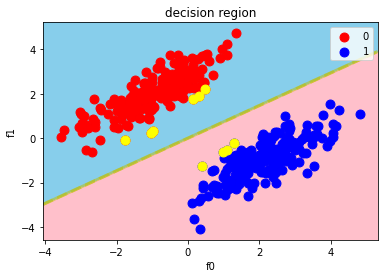

In [12]:
decision_region(X_train, y_train, ssvc, step=0.01, title='decision region', xlabel='f0', ylabel='f1', target_names=['0', '1'])

# 【問題6】（アドバンス課題）多項式カーネル関数の作成

In [13]:
def polynomial_kernel(X):
        """
        カーネルトリックを行う：多項式カーネル
        
        Parameters
        ----------
         X : 次の形のndarray, shape (n_samples, n_features)
              訓練データの特徴量
              
        Returns
        -------
            次の形のndarray, shape (n_samples, n_samples)
        """
        
        K = (gamma * X.dot(X.T) + theta_0)**d
        
        return K

In [14]:
gamma = 1
theta_0 = 0
d = 1

In [15]:
polynomial_kernel(X)

array([[ 5.84834156, -4.28053661, -2.72096008, ..., -4.85507427,
        -3.09411122,  2.10896519],
       [-4.28053661,  3.13389846,  2.0451221 , ...,  3.5236277 ,
         2.29431684, -1.5693301 ],
       [-2.72096008,  2.0451221 ,  4.54941793, ...,  0.42596695,
         3.2571986 , -2.55771625],
       ...,
       [-4.85507427,  3.5236277 ,  0.42596695, ...,  5.05362835,
         1.55398335, -0.87075868],
       [-3.09411122,  2.29431684,  3.2571986 , ...,  1.55398335,
         2.64317102, -1.98848275],
       [ 2.10896519, -1.5693301 , -2.55771625, ..., -0.87075868,
        -1.98848275,  1.51745052]])

In [16]:
# 線形カーネルの出力と一致

K = X.dot(X.T)
K

array([[ 5.84834156, -4.28053661, -2.72096008, ..., -4.85507427,
        -3.09411122,  2.10896519],
       [-4.28053661,  3.13389846,  2.0451221 , ...,  3.5236277 ,
         2.29431684, -1.5693301 ],
       [-2.72096008,  2.0451221 ,  4.54941793, ...,  0.42596695,
         3.2571986 , -2.55771625],
       ...,
       [-4.85507427,  3.5236277 ,  0.42596695, ...,  5.05362835,
         1.55398335, -0.87075868],
       [-3.09411122,  2.29431684,  3.2571986 , ...,  1.55398335,
         2.64317102, -1.98848275],
       [ 2.10896519, -1.5693301 , -2.55771625, ..., -0.87075868,
        -1.98848275,  1.51745052]])